In [25]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
os.listdir('../data/phase_2')

['.ipynb_checkpoints',
 'FCFC Import Naphtha Composition Lab_001~100_R2.xlsx',
 'train(add_split_factor).csv',
 'train.csv',
 'transform_matrix.csv']

# some function

In [26]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [27]:
df = pd.read_csv('../data/phase_2/train(add_split_factor).csv',index_col=0)
print(df.shape)
df.head()

(14005, 436)


Case Conditions_Feed Rate to C013 (Input)  \
0                                       10.0   
1                                       10.0   
2                                       10.0   
3                                       10.0   
4                                       10.0   

   Case Conditions_C7+ in Light End (Input)  \
0                                       2.5   
1                                       5.0   
2                                      10.0   
3                                       2.5   
4                                       5.0   

   Case Conditions_Heart Cut Prod. Rate (Input)  \
0                                         100.0   
1                                         100.0   
2                                         100.0   
3                                         100.0   
4                                         100.0   

   Case Conditions_C6P- in Heart Cut (Input)  \
0                                        1.0   
1                                        1.0   
2                                        1.0   
3                                        1.5   
4                                        1.5   

   Case Conditions_Feed Rate to C013 (Results)  \
0                                    10.000001   
1                                    10.000001   
2                                    10.000001   
3                                    10.000001   
4                                    10.000001   

   Case Conditions_C7+ in Light End (Results)  \
0                                    2.500057   
1                                    4.999882   
2                                   10.000006   
3                                    2.500020   
4                                    5.000001   

   Case Conditions_Heart Cut Prod. Rate (Results)  \
0                                      100.000198   
1                                      100.000122   
2                                      100.000008   
3                                      100.000275   
4                                       99.999817   

   Case Conditions_C6P- in Heart Cut (Results)  \
0                                     1.000427   
1                                     1.000401   
2                                     0.999993   
3                                     1.500293   
4                                     1.499961   

   Case Conditions_C10+ in Heart Cut (Results)  \
0                                     6.138641   
1                                     6.249050   
2                                     6.376052   
3                                     6.316332   
4                                     6.416863   

   Naphtha Properties_Naphtha Feed Rate  ...  \
0                            118.000084  ...   
1                            118.000000  ...   
2                            118.000000  ...   
3                            118.000000  ...   
4                            118.000084  ...   

   Heavy End Split Factor_2,2,3,3-Tetramethylhexane  \
0                                          0.348342   
1                                          0.336983   
2                                          0.323372   
3                                          0.334064   
4                                          0.323809   

   Heavy End Split Factor_3-Methylnonane  \
0                               0.378793   
1                               0.367462   
2                               0.354403   
3                               0.360351   
4                               0.350009   

   Heavy End Split Factor_tert-Butylcyclohexane  \
0                                      0.381912   
1                                      0.370631   
2                                      0.357728   
3                                      0.362654   
4                                      0.352356   

   Heavy End Split Factor_n-Decane  Heavy End Split Factor_1,2-Diethylbenzene  \
0                         0.397334           

# define columns

In [28]:
case_col = df.columns[(df.columns.str.contains('Case'))&(df.columns.str.contains('Input'))].tolist()
case_col

['Case Conditions_Feed Rate to C013 (Input)',
 'Case Conditions_C7+ in Light End (Input)',
 'Case Conditions_Heart Cut Prod. Rate (Input)',
 'Case Conditions_C6P- in Heart Cut (Input)']

In [29]:
naphtha_col = df.columns[df.columns.str.contains('Naphtha Properties')].tolist()[5:-1]
print(len(naphtha_col))
naphtha_col[0],naphtha_col[-1]

54


('Naphtha Properties_Oxygen', 'Naphtha Properties_n-Tridecane')

In [30]:
s_col = get_group_col(df,'Individual Component')

# sorted s_col
temp = []
for i in [i.split('_')[1] for i in naphtha_col]:
    col1 = 'Light End Split Factor_{}'.format(i)
    col2 = 'Heart Cut Split Factor_{}'.format(i)
    col3 = 'Heavy End Split Factor_{}'.format(i)
    cols = [col1,col2,col3]
    temp += cols
s_col = temp

print(len(s_col))

162


# 3d scatter

In [37]:
for i in range(3):
    idx = i+13
    fig = px.scatter_3d(df.sample(1000), 
                        x = case_col[0], 
                        y = case_col[1], 
                        z = case_col[2],
                        color = s_col[idx],)
    fig.show()

# build scaler

In [8]:
x_col = case_col + naphtha_col
y_col = s_col
ss = StandardScaler().fit(df[x_col])

#  features scale

In [9]:
df[x_col] = ss.transform(df[x_col])

# split train test

In [10]:
df = shuffle(df)

X = df[x_col]
Y = df[y_col]

sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]

# to torch tensor

In [11]:
X_train = torch.tensor(X_train.values,dtype=torch.float).cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float).cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float).cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float).cuda()

# data_iter

In [12]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [13]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [14]:
class Dual_net(nn.Module):
    def __init__(self):
        super(Dual_net,self).__init__()
        a = 3 # 4 to 3
        b = 54 # 54 to 54
        c = a+b
        self.C_net = self._build_C_net(4,a)
        self.N_net = self._build_N_net(54,b) 
        self.F_net = self._build_F_net(c,c)
        # build O_net
        self.O_net1 = self._build_O_net(c,3)
        self.O_net2 = self._build_O_net(c,3)
        self.O_net3 = self._build_O_net(c,3)
        self.O_net4 = self._build_O_net(c,3)
        self.O_net5 = self._build_O_net(c,3)
        self.O_net6 = self._build_O_net(c,3)
        self.O_net7 = self._build_O_net(c,3)
        self.O_net8 = self._build_O_net(c,3)
        self.O_net9 = self._build_O_net(c,3)
        self.O_net10 = self._build_O_net(c,3)
        self.O_net11 = self._build_O_net(c,3)
        self.O_net12 = self._build_O_net(c,3)
        self.O_net13 = self._build_O_net(c,3)
        self.O_net14 = self._build_O_net(c,3)
        self.O_net15 = self._build_O_net(c,3)
        self.O_net16 = self._build_O_net(c,3)
        self.O_net17 = self._build_O_net(c,3)
        self.O_net18 = self._build_O_net(c,3)
        self.O_net19 = self._build_O_net(c,3)
        self.O_net20 = self._build_O_net(c,3)
        self.O_net21 = self._build_O_net(c,3)
        self.O_net22 = self._build_O_net(c,3)
        self.O_net23 = self._build_O_net(c,3)
        self.O_net24 = self._build_O_net(c,3)
        self.O_net25 = self._build_O_net(c,3)
        self.O_net26 = self._build_O_net(c,3)
        self.O_net27 = self._build_O_net(c,3)
        self.O_net28 = self._build_O_net(c,3)
        self.O_net29 = self._build_O_net(c,3)
        self.O_net30 = self._build_O_net(c,3)
        self.O_net31 = self._build_O_net(c,3)
        self.O_net32 = self._build_O_net(c,3)
        self.O_net33 = self._build_O_net(c,3)
        self.O_net34 = self._build_O_net(c,3)
        self.O_net35 = self._build_O_net(c,3)
        self.O_net36 = self._build_O_net(c,3)
        self.O_net37 = self._build_O_net(c,3)
        self.O_net38 = self._build_O_net(c,3)
        self.O_net39 = self._build_O_net(c,3)
        self.O_net40 = self._build_O_net(c,3)
        self.O_net41 = self._build_O_net(c,3)
        self.O_net42 = self._build_O_net(c,3)
        self.O_net43 = self._build_O_net(c,3)
        self.O_net44 = self._build_O_net(c,3)
        self.O_net45 = self._build_O_net(c,3)
        self.O_net46 = self._build_O_net(c,3)
        self.O_net47 = self._build_O_net(c,3)
        self.O_net48 = self._build_O_net(c,3)
        self.O_net49 = self._build_O_net(c,3)
        self.O_net50 = self._build_O_net(c,3)
        self.O_net51 = self._build_O_net(c,3)
        self.O_net52 = self._build_O_net(c,3)
        self.O_net53 = self._build_O_net(c,3)
        self.O_net54 = self._build_O_net(c,3)
        # O_nets list
        self.O_nets = [self.O_net1,self.O_net2,self.O_net3,self.O_net4,self.O_net5,
                       self.O_net6,self.O_net7,self.O_net8,self.O_net9,self.O_net10,
                       self.O_net11,self.O_net12,self.O_net13,self.O_net14,self.O_net15,
                       self.O_net16,self.O_net17,self.O_net18,self.O_net19,self.O_net20,
                       self.O_net21,self.O_net22,self.O_net23,self.O_net24,self.O_net25,
                       self.O_net26,self.O_net27,self.O_net28,self.O_net29,self.O_net30,
                       self.O_net31,self.O_net32,self.O_net33,self.O_net34,self.O_net35,
                       self.O_net36,self.O_net37,self.O_net38,self.O_net39,self.O_net40,
                       self.O_net41,self.O_net42,self.O_net43,self.O_net44,self.O_net45,
                       self.O_net46,self.O_net47,self.O_net48,self.O_net49,self.O_net50,
                       self.O_net51,self.O_net52,self.O_net53,self.O_net54]
        # initialize weight
        self.apply(self._init_weights)
            
    def forward(self,x):
        c,n = self._Fetch(x)
        c,n = self.C_net(c),self.N_net(n)
        f = torch.cat((c,n),dim=1)
        f = self.F_net(f)
        output = torch.tensor([]).cuda()
        for i in self.O_nets:
            v = F.sigmoid(i(f)) # range[0,1]
            output = torch.cat((output,v),dim=1)
        return output
    
    @staticmethod
    def _Fetch(x):
        return x[:,:4],x[:,4:]
    
    @staticmethod
    def _build_C_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_N_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_F_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_O_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            ReLU(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _init_weights(m):
        if hasattr(m,'weight'):
            torch.nn.init.xavier_uniform(m.weight)
        if hasattr(m,'bias'):
            m.bias.data.fill_(0)

In [15]:
net = Dual_net().cuda()

# forward test

In [16]:
y = net(X_test)
print(y.shape)
y[0].detach().cpu().numpy().sum()

torch.Size([1403, 162])


81.54284

# torchviz

In [17]:
#y = net(X_test)
#dot = torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))
#dot.render("./data/model_2.png")

# tensorboard

In [18]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [19]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [20]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = 1e+12
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0300 valid loss 0.0048
record net
epochs 1 train loss 0.0038 valid loss 0.0032
record net
epochs 2 train loss 0.0024 valid loss 0.0021
record net
epochs 3 train loss 0.0017 valid loss 0.0016
record net
epochs 4 train loss 0.0014 valid loss 0.0014
record net
epochs 5 train loss 0.0012 valid loss 0.0012
record net
epochs 6 train loss 0.0010 valid loss 0.0010
record net
epochs 7 train loss 0.0009 valid loss 0.0008
record net
epochs 8 train loss 0.0007 valid loss 0.0007
record net
epochs 9 train loss 0.0006 valid loss 0.0007
record net
epochs 10 train loss 0.0006 valid loss 0.0006
record net
epochs 11 train loss 0.0005 valid loss 0.0006
record net
epochs 12 train loss 0.0005 valid loss 0.0005
record net
epochs 13 train loss 0.0005 valid loss 0.0005
record net
epochs 14 train loss 0.0004 valid loss 0.0004
record net
epochs 15 train loss 0.0004 valid loss 0.0004
record net
epochs 16 train loss 0.0003 valid loss 0.0003
record net
epochs 17 train loss 0.0003 valid loss 0.

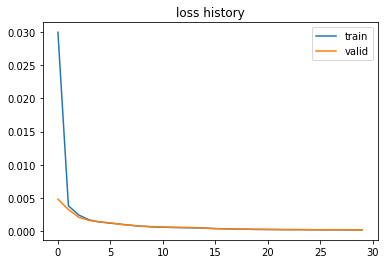

In [21]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=30)

# make prediction

In [22]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_real = Y_test.cpu().detach().numpy()
y_real = pd.DataFrame(y_real,columns=y_col)

In [23]:
y_pred.head()

Individual Component to Light End Split Factor_Oxygen  \
0                                           0.999993       
1                                           0.999597       
2                                           0.999975       
3                                           0.999318       
4                                           0.998706       

   Individual Component to Heart Cut Split Factor_Oxygen  \
0                                           0.000005       
1                                           0.000455       
2                                           0.000012       
3                                           0.000342       
4                                           0.001343       

   Individual Component to Heavy End Split Factor_Oxygen  \
0                                           0.000003       
1                                           0.000274       
2                                           0.000021       
3                                           0.000834       
4                                           0.000896       

   Individual Component to Light End Split Factor_Methane  \
0                                           0.999987        
1                                           0.999304        
2                                           0.999969        
3                                           0.999138        
4                                           0.998094        

   Individual Component to Heart Cut Split Factor_Methane  \
0                                           0.000011        
1                                           0.000759        
2                                           0.000038        
3                                           0.001072        
4                                           0.001541        

   Individual Component to Heavy End Split Factor_Methane  \
0                                           0.000009        
1                                           0.000943        
2                                           0.000032        
3                                           0.000557        
4                                           0.002122        

   Individual Component to Light End Split Factor_Ethane  \
0                                           0.999991       
1                                           0.999401       
2                                           0.999986       
3                                           0.999209       
4                                           0.997839       

   Individual Component to Heart Cut Split Factor_Ethane  \
0                                           0.000004       
1                                           0.000451       
2                                           0.000009       
3                                           0.000691       
4                                           0.001436       

   Individual Component to Heavy End Split Factor_Ethane  \
0                                           0.000008       
1                                           0.000518       
2                                           0.000028       
3                                           0.000918       
4                                           0.001344       

   Individual Component to Light End Split Factor_Propane  ...  \
0                                           0.999828       ...   
1                                           0.999539       ...   
2                                           0.999990       ...   
3                                           0.999975       ...   
4                                           0.999446       ...   

   Individual Component to Heavy End Split Factor_n-Pentylbenzene  \
0                                           0.426396                
1                                           0.462172                
2                                           0.543832                
3                                           0.439521           

In [24]:
y_real.head()

Individual Component to Light End Split Factor_Oxygen  \
0                                                1.0       
1                                                1.0       
2                                                1.0       
3                                                1.0       
4                                                1.0       

   Individual Component to Heart Cut Split Factor_Oxygen  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Heavy End Split Factor_Oxygen  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Light End Split Factor_Methane  \
0                                                1.0        
1                                                1.0        
2                                                1.0        
3                                                1.0        
4                                                1.0        

   Individual Component to Heart Cut Split Factor_Methane  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   Individual Component to Heavy End Split Factor_Methane  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   Individual Component to Light End Split Factor_Ethane  \
0                                                1.0       
1                                                1.0       
2                                                1.0       
3                                                1.0       
4                                                1.0       

   Individual Component to Heart Cut Split Factor_Ethane  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Heavy End Split Factor_Ethane  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Light End Split Factor_Propane  ...  \
0                                           0.987422       ...   
1                                           0.983036       ...   
2                                           0.989715       ...   
3                                           0.983931       ...   
4                                           0.989077       ...   

   Individual Component to Heavy End Split Factor_n-Pentylbenzene  \
0                                           0.416182                
1                                           0.457668                
2                                           0.536580                
3                                           0.434613           

# metric

In [25]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

MSE       MAPE
Individual Component to Light End Split Factor_...  7.58225e-07  0.0407365
Individual Component to Heart Cut Split Factor_...  4.87031e-07        inf
Individual Component to Heavy End Split Factor_...   6.5082e-07        inf
Individual Component to Light End Split Factor_...  1.17886e-06  0.0532008
Individual Component to Heart Cut Split Factor_...  1.43444e-06        inf
...                                                         ...        ...
Individual Component to Heavy End Split Factor_...  0.000685464        inf
Individual Component to Light End Split Factor_...  1.93394e-06        inf
Individual Component to Heart Cut Split Factor_...  2.10711e-06        inf
Individual Component to Heavy End Split Factor_...   2.4351e-06  0.0721985
AVG                                                 0.000171177        inf

[163 rows x 2 columns]

#  wrap model

In [26]:
n_col = [i.split('_')[1] for i in x_col[4:]]

In [27]:
class ANN_wrapper(object):
    def __init__(self,x_col,y_col,n_col,scaler,net):
        self.x_col = x_col
        self.y_col = y_col
        self.n_col = n_col
        self.scaler = scaler
        self.net = net
    
    def predict(self,x):
        x = self.scaler.transform(x)
        x = torch.tensor(x,dtype=torch.float).cuda()
        y = self.net(x).detach().cpu().numpy()
        y = pd.DataFrame(y,columns=self.y_col)
        y = self.normalize(y)
        return y
    
    def normalize(self,y):
        for i in self.n_col:
            le = 'Individual Component to Light End Split Factor_'+i
            hc = 'Individual Component to Heart Cut Split Factor_'+i
            he = 'Individual Component to Heavy End Split Factor_'+i
            col = [le,hc,he]
            y[col] = y[col].values / y[col].sum(axis=1).values.reshape(-1,1)
        return y

In [28]:
model = ANN_wrapper(x_col,y_col,n_col,ss,net.eval())

# test ANN_wrapper

In [29]:
data = pd.read_csv('../data/phase_2/train(add_split_factor).csv',index_col=0).sample(1000)
x = data[x_col]
y_real = data[y_col]
x

Case Conditions_Feed Rate to C013 (Input)  \
6304                                        30.0   
10284                                       10.0   
3122                                        30.0   
13957                                       20.0   
6151                                        10.0   
...                                          ...   
12252                                       30.0   
9158                                        10.0   
1864                                        20.0   
13651                                       10.0   
3529                                        30.0   

       Case Conditions_C7+ in Light End (Input)  \
6304                                        5.0   
10284                                       5.0   
3122                                       10.0   
13957                                       2.5   
6151                                        5.0   
...                                         ...   
12252                                      10.0   
9158                                       10.0   
1864                                        5.0   
13651                                       2.5   
3529                                        2.5   

       Case Conditions_Heart Cut Prod. Rate (Input)  \
6304                                          100.0   
10284                                         100.0   
3122                                          100.0   
13957                                         100.0   
6151                                          100.0   
...                                             ...   
12252                                         100.0   
9158                                          100.0   
1864                                          100.0   
13651                                         100.0   
3529                                          110.0   

       Case Conditions_C6P- in Heart Cut (Input)  Naphtha Properties_Oxygen  \
6304                                         1.5                        0.0   
10284                                        2.0                        0.0   
3122                                         1.0                        0.0   
13957                                        0.5                        0.0   
6151                                         1.0                        0.0   
...                                          ...                        ...   
12252                                        2.0                        0.0   
9158                                         1.5                        0.0   
1864                                         2.0                        0.0   
13651                                        2.0                        0.0   
3529                                         0.7                        0.0   

       Naphtha Properties_Methane  Naphtha Properties_Ethane  \
6304                          0.0                        0.0   
10284                         0.0                        0.0   
3122                          0.0                        0.0   
13957                         0.0                        0.0   
6151                          0.0                        0.0   
...                           ...                        ...   
12252                         0.0                        0.0   
9158                          0.0                        0.0   
1864                          0.0                        0.0   
13651                         0.0                        0.0   
3529                          0.0                        0.0   

       Naphtha Properties_Propane  Naphtha Properties_n-Butane  \
6304                     0.074998                     0.148997   
10284                    0.056001                     0.112002   
3122                     0.019000                     0.037000   
13957                    0.038001                     0.076002   
6151                     0.046000                     0.0929

In [30]:
y_pred = model.predict(x)
y_pred.head()

Individual Component to Light End Split Factor_Oxygen  \
0                                           0.999509       
1                                           0.997962       
2                                           0.999277       
3                                           0.999999       
4                                           0.998636       

   Individual Component to Heart Cut Split Factor_Oxygen  \
0                                       2.427276e-04       
1                                       5.726455e-04       
2                                       4.283089e-04       
3                                       8.285993e-07       
4                                       6.103204e-04       

   Individual Component to Heavy End Split Factor_Oxygen  \
0                                       2.483654e-04       
1                                       1.465373e-03       
2                                       2.948825e-04       
3                                       5.728009e-07       
4                                       7.532810e-04       

   Individual Component to Light End Split Factor_Methane  \
0                                           0.998870        
1                                           0.998007        
2                                           0.998447        
3                                           0.999998        
4                                           0.997836        

   Individual Component to Heart Cut Split Factor_Methane  \
0                                           0.000621        
1                                           0.001240        
2                                           0.000850        
3                                           0.000001        
4                                           0.001284        

   Individual Component to Heavy End Split Factor_Methane  \
0                                           0.000509        
1                                           0.000753        
2                                           0.000703        
3                                           0.000001        
4                                           0.000880        

   Individual Component to Light End Split Factor_Ethane  \
0                                           0.999285       
1                                           0.997740       
2                                           0.999090       
3                                           1.000000       
4                                           0.997633       

   Individual Component to Heart Cut Split Factor_Ethane  \
0                                       2.693093e-04       
1                                       1.032277e-03       
2                                       3.209482e-04       
3                                       6.136323e-08       
4                                       1.018918e-03       

   Individual Component to Heavy End Split Factor_Ethane  \
0                                       4.452779e-04       
1                                       1.227848e-03       
2                                       5.891238e-04       
3                                       3.555326e-07       
4                                       1.348235e-03       

   Individual Component to Light End Split Factor_Propane  ...  \
0                                           0.993144       ...   
1                                           0.987209       ...   
2                                           0.989960       ...   
3                                           0.999447       ...   
4                                           0.989820       ...   

   Individual Component to Heavy End Split Factor_n-Pentylbenzene  \
0                                           0.507970                
1                                           0.396000                
2                                           0.449987                
3                                           0.399159           

In [31]:
y_pred.sum(axis=1).head(5)

0    54.0
1    54.0
2    54.0
3    54.0
4    54.0
dtype: float32

In [32]:
y_real = y_real.reset_index(drop=True)
y_real.head()

Individual Component to Light End Split Factor_Oxygen  \
0                                                1.0       
1                                                1.0       
2                                                1.0       
3                                                1.0       
4                                                1.0       

   Individual Component to Heart Cut Split Factor_Oxygen  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Heavy End Split Factor_Oxygen  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Light End Split Factor_Methane  \
0                                                1.0        
1                                                1.0        
2                                                1.0        
3                                                1.0        
4                                                1.0        

   Individual Component to Heart Cut Split Factor_Methane  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   Individual Component to Heavy End Split Factor_Methane  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   Individual Component to Light End Split Factor_Ethane  \
0                                                1.0       
1                                                1.0       
2                                                1.0       
3                                                1.0       
4                                                1.0       

   Individual Component to Heart Cut Split Factor_Ethane  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Heavy End Split Factor_Ethane  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   Individual Component to Light End Split Factor_Propane  ...  \
0                                           0.988610       ...   
1                                           0.993798       ...   
2                                           0.983891       ...   
3                                           0.990084       ...   
4                                           0.995325       ...   

   Individual Component to Heavy End Split Factor_n-Pentylbenzene  \
0                                           0.509346                
1                                           0.392790                
2                                           0.446722                
3                                           0.390130           

In [33]:
y_real.sum(axis=1).head(5)

0    54.000009
1    53.999998
2    54.000001
3    54.000004
4    54.000003
dtype: float64

In [34]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

MSE       MAPE
Individual Component to Light End Split Factor_...  1.82881e-06  0.0675251
Individual Component to Heart Cut Split Factor_...  4.29651e-07        inf
Individual Component to Heavy End Split Factor_...  5.27814e-07        inf
Individual Component to Light End Split Factor_...  4.60992e-06   0.111081
Individual Component to Heart Cut Split Factor_...  1.32781e-06        inf
...                                                         ...        ...
Individual Component to Heavy End Split Factor_...   0.00110841        inf
Individual Component to Light End Split Factor_...  1.68074e-06        inf
Individual Component to Heart Cut Split Factor_...  1.67121e-06        inf
Individual Component to Heavy End Split Factor_...  6.65481e-06   0.124296
AVG                                                 0.000645924        inf

[163 rows x 2 columns]

# save model

In [35]:
joblib.dump(model,'../model/ANN(58_to_sp162).pkl')
print('save done!')

save done!
